# Reinforcement Q-learning with Chopsticks game

with code modified from:

    [1] https://medium.com/@apoddar573/making-your-own-custom-environment-in-gym-c3b65ff8cdaa
    
    -> (https://github.com/apoddar573/Tic-Tac-Toe-Gym_Environment/blob/master/gym-tictac4/gym_tictac4/envs/tictac4_env.py)
    
    [2] https://www.geeksforgeeks.org/q-learning-in-python/

In [1]:
import gym 
import itertools 
import matplotlib 
import matplotlib.style 
import numpy as np 
import pandas as pd 
import sys 

from collections import defaultdict 
import gym_chop

In [2]:
import matplotlib
import numpy as np
import pandas as pd
import copy
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=20, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [3]:
matplotlib.style.use('ggplot') 

env = gym.make('chop-v0')


def createEpsilonGreedyPolicy(Q, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy based
    on a given Q-function and epsilon.
    Returns a function that takes the state
    as an input and returns the probabilities
    for each action in the form of a numpy array
    of length of the action space(set of possible actions).
    """
    def policyFunction(state):

        Action_probabilities = np.ones(num_actions,
                dtype = float) * epsilon / num_actions

        best_action = np.argmax(Q[tuple(tuple(x) for x in state)])
        Action_probabilities[best_action] += (1.0 - epsilon)
        return Action_probabilities

    return policyFunction

def qLearning(env, num_episodes, discount_factor = 0.90,
                            alpha = 0.60, epsilon = 0.1, debug = 0, static = 0, stoptrain=2000):
    """
    Q-Learning algorithm: Off-policy TD control.
    Finds the optimal greedy policy while improving
    following an epsilon-greedy policy 0.9, 0.6, 0.1 defaults"""

    # Action value function
    # A nested dictionary that maps
    # state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(5))#env.action_space.n))

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths = np.zeros(num_episodes),
        episode_rewards = np.zeros(num_episodes))

    # Create an epsilon greedy policy function
    # appropriately for environment action space
    policy = createEpsilonGreedyPolicy(Q, epsilon, 5)#env.action_space.n)
    total_win = [0,0]
    
    # For every episode
    for ith_episode in range(num_episodes):
        #############TO BE IMPLEMENTED (lower epsilon at certain point)
#         if ith_episode == stoptrain:
#             epsilon = 0 #100% Greedy from this point on
#             policy = createEpsilonGreedyPolicy(Q, epsilon, 5)
        #####################################################
        # Reset the environment and pick the first action
        state = copy.deepcopy(env.reset()) #Python points to the same list otherwise!

        for t in itertools.count():

            # get probabilities of all actions from current state
            action_probabilities = policy(state)

            # choose action according to
            # the probability distribution
            action = np.random.choice(np.arange(
                      len(action_probabilities)),
                       p = action_probabilities)

            #action = np.random.randint(4) # TEST REMOVE AFTER 0:5 or 0:4
            
            # take action and get reward, transit to next state
            next_state, reward, done, add, count = env.step(action)
            if debug:
                print("cur/next: ", state, next_state)

            ############## Remove invalid moves, set to low score. TO BE IMPLEMENTED
#             if reward == -1000: #set reward to -1000 for invalid moves
#                 Q[tuple(tuple(x) for x in state)][action] += reward
#                 continue
            ################

            # Update statistics
            stats.episode_rewards[ith_episode] += reward
            stats.episode_lengths[ith_episode] = count
            
            # take random/static action for p2?
            # p2 needs to be static maybe?
            p2count = 1
            while (count%2 == 1 and done == 0):
                if static:
                    next_state, reward, done, add, count = env.step(p2count)#np.random.randint(5)) or p2count #untrack reward for p2
                else:
                    next_state, reward, done, add, count = env.step(np.random.randint(5))
                p2count = (p2count + 1)%5

            # TD Update

            best_next_action = np.argmax(Q[tuple(tuple(x) for x in next_state)])
            td_target = reward + discount_factor * Q[tuple(tuple(x) for x in next_state)][best_next_action]
            #
            best_val = np.max(Q[tuple(tuple(x) for x in next_state)])
            td_target = reward + discount_factor * best_val
            if debug:
                print("old val: ", state, next_state, Q[tuple(tuple(x) for x in state)][action])
            #
            td_delta = td_target - Q[tuple(tuple(x) for x in state)][action]
            Q[tuple(tuple(x) for x in state)][action] += alpha * td_delta
            if debug:
                print("new val: ", state, Q[tuple(tuple(x) for x in state)][action])

            # done is True if episode terminated
            if done:
                print(t," done")
                break

            state = copy.deepcopy(next_state)
        total_win = [sum(x) for x in zip(total_win,add)] #count victories
        if (ith_episode%5 == 0):
            print(ith_episode)

    return Q, stats, total_win


In [4]:
Q, stats,tot = qLearning(env, 2500, discount_factor = 0.01, alpha = 0.3, epsilon = 0.1)

[[1, 1], [2, 1]]
[[1, 2], [2, 1]]
[[1, 2], [3, 1]]
[[4, 2], [3, 1]]
[[4, 2], [2, 1]]
[[4, 4], [2, 1]]
[[4, 4], [1, 1]]
[[0, 4], [1, 1]]
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
[[0, 4], [0, 1]]
Invalid Step
Invalid Step
Invalid Step
[[1, 4], [0, 1]]
[[1, 4], [1, 1]]
[[1, 0], [1, 1]]
[[1, 0], [2, 1]]
Invalid Step
[[1, 2], [2, 1]]
[[1, 2], [3, 1]]
[[2, 2], [3, 1]]
[[2, 2], [0, 1]]
Invalid Step
Invalid Step
[[2, 3], [0, 1]]
[[2, 3], [2, 1]]
[[3, 3], [2, 1]]
[[3, 3], [0, 1]]
Invalid Step
[[4, 3], [0, 1]]
[[4, 3], [4, 1]]
[[4, 2], [4, 1]]
[[4, 2], [3, 1]]
Invalid Step
[[0, 2], [3, 1]]
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
Invalid Step
[[0, 2], [0, 1]]
[[1, 2], [0, 1]]
Invalid Step
[[1,

In [5]:
print(Q[((2,3),(0,4))])
print(Q[((1,3),(0,4))])

print(Q[((0,0),(0,1))])
print(Q[((4,0),(0,1))])

print(Q[((3,3),(0,0))])
print(Q[((3,3),(2,0))])

print(Q[((2,3),(0,0))])
print(Q[((2,3),(2,0))])

[0.         0.         0.         0.30360829 0.        ]
[7.48860839e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0. 0. 0. 0. 0.]
[-2.09999901e+01  1.00000000e+02  5.10000000e-01  2.98575732e-01
  3.02590823e-06]
[0. 0. 0. 0. 0.]
[1.00000000e+02 7.43064816e-10 3.00000000e+01 2.46738371e-08
 5.09995244e-01]
[0. 0. 0. 0. 0.]
[1.12997312e-01 2.59544268e-06 0.00000000e+00 1.70224389e-08
 0.00000000e+00]


('W/L: ', [2317, 183])


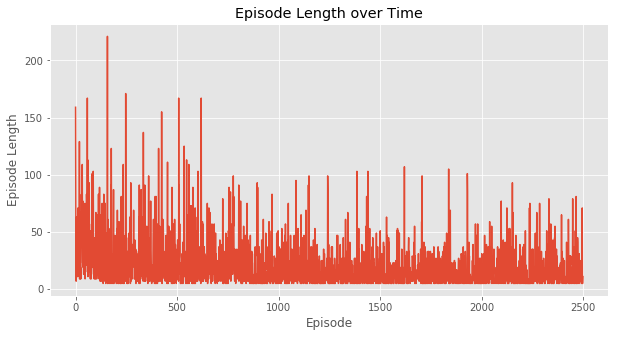

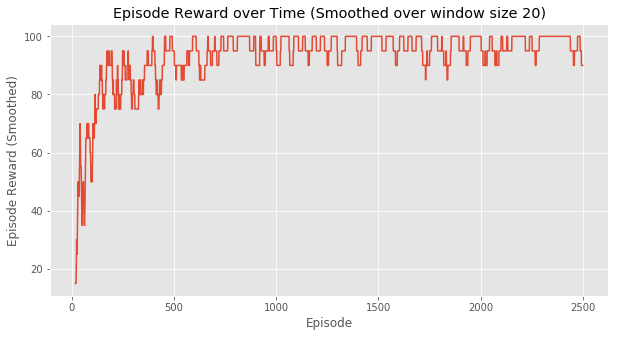

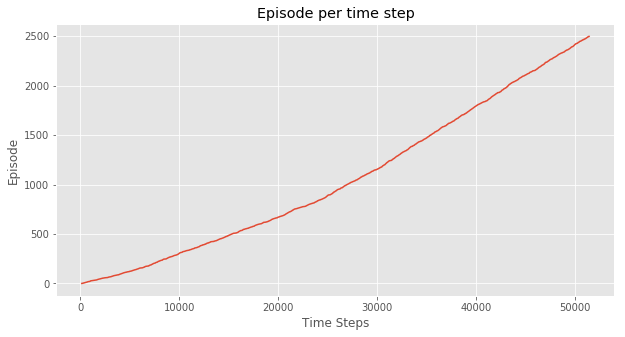

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [6]:
print("W/L: ", tot)
plot_episode_stats(stats)